<a href="https://colab.research.google.com/github/Soham0936/stockpredictiontesla/blob/main/TeslaStockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
data=pd.read_csv("TSLA.csv")

In [6]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [9]:
def check_df(dataframe, head=5):
    print("#################### Shape ####################")
    print(dataframe.shape)

    print("\n#################### Types ####################")
    print(dataframe.dtypes)

    print("\n#################### Head ####################")
    print(dataframe.head(head))

    print("\n#################### Tail ####################")
    print(dataframe.tail(head))

    print("\n#################### NA ####################")
    print(dataframe.isnull().sum())

    print("\n#################### Quantiles ####################")
    numeric_cols = dataframe.select_dtypes(include=['number'])  # Select only numeric columns
    print(numeric_cols.quantile([0, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T)


In [10]:
check_df(data)

#################### Shape ####################
(2416, 7)

#################### Types ####################
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

#################### Head ####################
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900

#################### Tail ####################
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.6900

In [11]:
data["Date"]=pd.to_datetime(data["Date"])

In [12]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [13]:
tesla_data=data[["Date","Close"]]

In [14]:
tesla_data.head()

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001


In [15]:
print("Min. Tarih:",tesla_data["Date"].min())
print("Max. Tarih:",tesla_data["Date"].max())

Min. Tarih: 2010-06-29 00:00:00
Max. Tarih: 2020-02-03 00:00:00


In [16]:
tesla_data

,Date,Close
0,2010-06-29,23.889999
1,2010-06-30,23.830000
2,2010-07-01,21.959999
3,2010-07-02,19.200001
4,2010-07-06,16.110001
...,...,...
2411,2020-01-28,566.900024
2412,2020-01-29,580.989990
2413,2020-01-30,640.809998
2414,2020-01-31,650.570007


In [17]:
tesla_data.drop("Date",axis=1,inplace=True)

In [18]:
tesla_data

,Close
0,23.889999
1,23.830000
2,21.959999
3,19.200001
4,16.110001
...,...
2411,566.900024
2412,580.989990
2413,640.809998
2414,650.570007


In [19]:
result_data=tesla_data.copy()

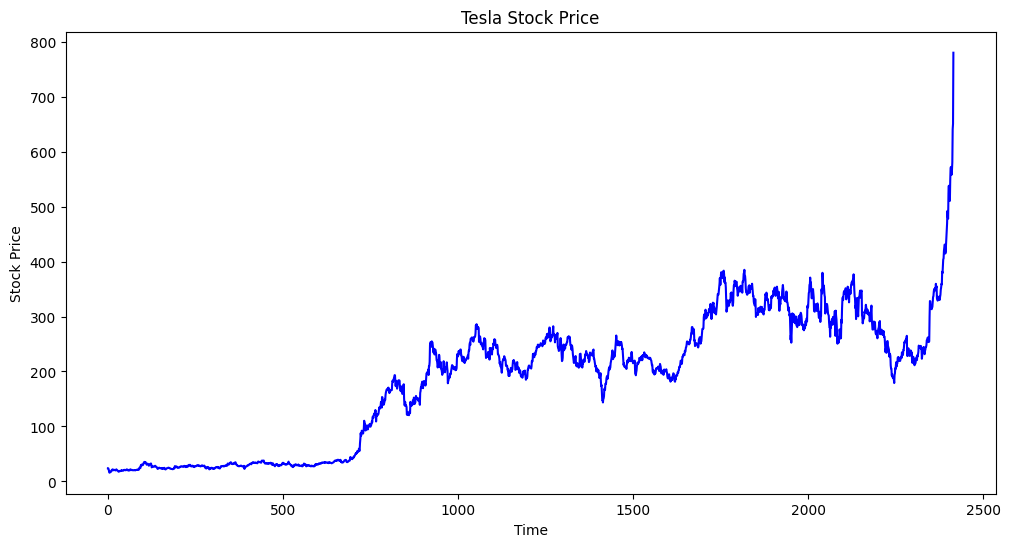

In [20]:
plt.figure(figsize=(12,6))
plt.plot(tesla_data["Close"],color="blue");
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price")
plt.xlabel("Time")
plt.show()

In [21]:
tesla_data=tesla_data.values

In [22]:
tesla_data[0:5]

array([[23.889999],
       [23.83    ],
       [21.959999],
       [19.200001],
       [16.110001]])

In [23]:
tesla_data=tesla_data.astype("float32")

In [24]:
def split_data(dataframe,test_size):
    pos=int(round(len(dataframe)*(1-test_size)))
    train=dataframe[:pos]
    test=dataframe[pos:]
    return train,test,pos

In [25]:
train,test,pos=split_data(tesla_data,0.20)
print(train.shape,test.shape)

(1933, 1) (483, 1)


In [26]:
scaler_train=MinMaxScaler(feature_range=(0,1))
train=scaler_train.fit_transform(train)
scaler_test=MinMaxScaler(feature_range=(0,1))
test=scaler_test.fit_transform(test)
train[0:5]

array([[0.02191224],
       [0.02174973],
       [0.01668472],
       [0.0092091 ],
       [0.00083966]], dtype=float32)

In [27]:
test[0:5]

array([[0.25685903],
       [0.24829045],
       [0.25511202],
       [0.24978784],
       [0.2465767 ]], dtype=float32)

In [28]:
def create_features(data,lookback):
    X,Y=[],[]
    for i in range(lookback,len(data)):
        X.append(data[i-lookback:i,0])
        Y.append(data[i,0])
    return np.array(X),np.array(Y)
lookback=20

In [29]:
X_train,y_train=create_features(train,lookback)

In [30]:
X_test,y_test=create_features(test,lookback)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [31]:
X_train[0:5]

array([[0.02191224, 0.02174973, 0.01668472, 0.0092091 , 0.00083966,
        0.        , 0.00449621, 0.00433369, 0.0033857 , 0.00633803,
        0.01094258, 0.011078  , 0.01310942, 0.0165493 , 0.01218851,
        0.01197183, 0.01408451, 0.01486999, 0.01394908, 0.01286566],
       [0.02174973, 0.01668472, 0.0092091 , 0.00083966, 0.        ,
        0.00449621, 0.00433369, 0.0033857 , 0.00633803, 0.01094258,
        0.011078  , 0.01310942, 0.0165493 , 0.01218851, 0.01197183,
        0.01408451, 0.01486999, 0.01394908, 0.01286566, 0.01332611],
       [0.01668472, 0.0092091 , 0.00083966, 0.        , 0.00449621,
        0.00433369, 0.0033857 , 0.00633803, 0.01094258, 0.011078  ,
        0.01310942, 0.0165493 , 0.01218851, 0.01197183, 0.01408451,
        0.01486999, 0.01394908, 0.01286566, 0.01332611, 0.01232395],
       [0.0092091 , 0.00083966, 0.        , 0.00449621, 0.00433369,
        0.0033857 , 0.00633803, 0.01094258, 0.011078  , 0.01310942,
        0.0165493 , 0.01218851, 0.01197183, 0

In [32]:
y_test[0:5]

array([0.14734703, 0.1796416 , 0.21088794, 0.20020628, 0.18416718],
      dtype=float32)

In [33]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1913, 1, 20) (1913, 1) (463, 1, 20) (463, 1)


In [34]:
model=Sequential()
model.add(LSTM(units=50,
              activation="relu",
              input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          14,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(loss="mean_squared_error",optimizer="adam")
callbacks=[EarlyStopping(monitor="val_loss",patience=3,verbose=1,mode="min"),
          ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",
                         save_best_only=True,save_weights_only=False,verbose=1)]
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test,y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/100
85/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 1: val_loss improved from inf to 0.00383, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 2/100
87/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 
Epoch 2: val_loss improved from 0.00383 to 0.00306, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 3/100
84/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 3: val_loss did not improve from 0.00306
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 4/100
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 4: val_loss did not improve from 0.00306
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 5/100
82/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012    
Epoch 5: val_loss improved from 0.00306 to 0.00273, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 6/100
85/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 6: val_loss did not improve from 0.00273
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 7/100
79/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011    
Epoch 7: val_loss improved from 0.00273 to 0.00252, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 8/100
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 8: val_loss did not improve from 0.00252
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 9/100
81/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011    
Epoch 9: val_loss improved from 0.00252 to 0.00242, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 10/100
85/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012    
Epoch 10: val_loss improved from 0.00242 to 0.00213, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 11/100
79/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012    
Epoch 11: val_loss improved from 0.00213 to 0.00202, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 12/100
82/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011    
Epoch 12: val_loss improved from 0.00202 to 0.00192, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 13/100
83/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012    
Epoch 13: val_loss did not improve from 0.00192
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 14/100
85/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011    
Epoch 14: val_loss did not improve from 0.00192
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 15/100
82/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010    
Epoch 15: val_loss improved from 0.00192 to 0.00181, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 16/100
83/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013    
Epoch 16: val_loss did not improve from 0.00181
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 17/100
81/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7534e-04
Epoch 17: val_loss improved from 0.00181 to 0.00168, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 18/100
82/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 18: val_loss did not improve from 0.00168
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 19/100
84/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 19: val_loss improved from 0.00168 to 0.00157, saving model to mymodel.h5


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 20/100
90/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 20: val_loss did not improve from 0.00157
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 21/100
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 21: val_loss did not improve from 0.00157
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 22/100
85/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 22: val_loss did not improve from 0.00157
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 22: early stopping


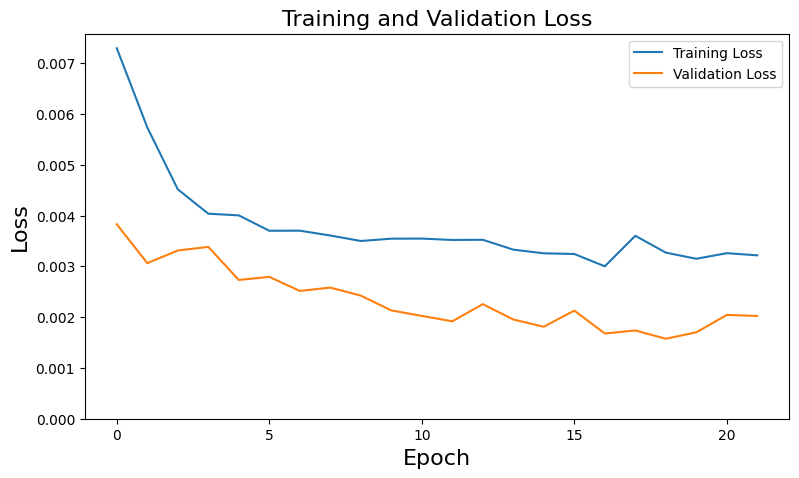

In [37]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

In [38]:
loss=model.evaluate(X_test,y_test,batch_size=20)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 


In [39]:
print("\nTest loss:%.1f%%"%(100.0*loss))


Test loss:0.2%


In [40]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler_train.inverse_transform(train_predict)
test_predict=scaler_test.inverse_transform(test_predict)
y_train=scaler_train.inverse_transform(y_train)
y_test=scaler_test.inverse_transform(y_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [41]:
train_rmse=np.sqrt(mean_squared_error(y_train,train_predict))
test_rmse=np.sqrt(mean_squared_error(y_test,test_predict,))
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:11.80004096589817
Test RMSE:27.035798253556916


In [42]:
train_prediction_data=result_data[lookback:pos]
train_prediction_data["Predicted"]=train_predict
train_prediction_data.head()

,Close,Predicted
20,20.719999,35.814323
21,20.350000,35.814323
22,19.940001,35.814323
23,20.920000,35.814323
24,21.950001,35.814323


In [43]:
test_prediction_data=result_data[pos+lookback:]
test_prediction_data["Predicted"]=test_predict
test_prediction_data.head()

,Close,Predicted
1953,267.529999,309.493286
1954,286.940002,307.960999
1955,305.720001,308.247070
1956,299.299988,312.126678
1957,289.660004,315.294861


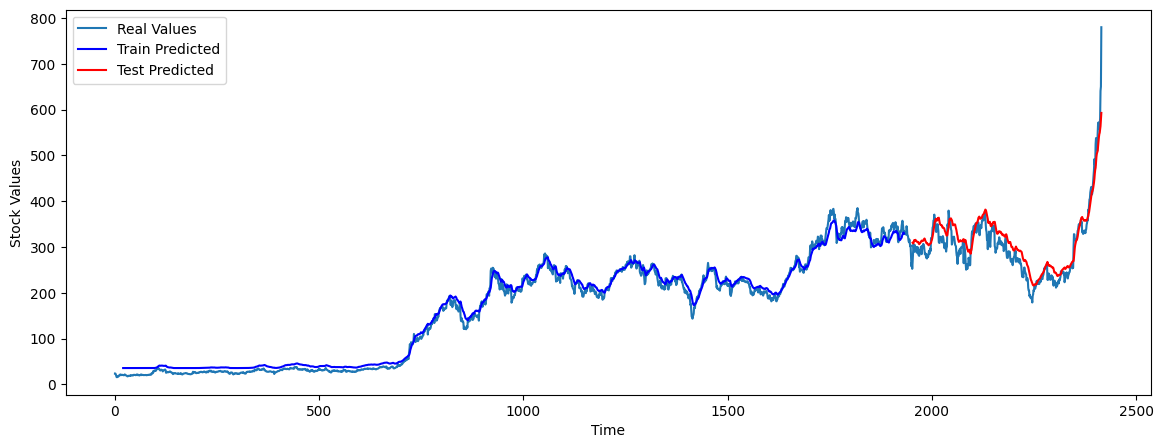

In [44]:
plt.figure(figsize=(14,5))
plt.plot(result_data,label="Real Values")
plt.plot(train_prediction_data["Predicted"],color="blue",label="Train Predicted")
plt.plot(test_prediction_data["Predicted"],color="red",label="Test Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Values")
plt.legend()
plt.show()